In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from heapq import heappush, heappop
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import evaluation
import data_loader
from model import MF, MUD
import pdb

In [2]:
params = dict()
params['lr'] = 1e-2
params['negNum_train'] = 3
params["negNum_test"] = 1000
params['epoch_limit'] = 3
params['w_decay'] = 1.
params['batch_size'] = 128
params['gpu'] = False
params['l_size'] = 16
params['epsilon'] = 0.01

In [4]:
category = 'Baby'
train, val, test = data_loader.read_data(category)
item_price = data_loader.get_price(category)
item_related = data_loader.get_related(category)
distribution = data_loader.get_distribution(category)
trainset = data_loader.TransactionData(train, item_related, \
            item_price, distribution)
testset = data_loader.UserTransactionData(test, item_price, \
            trainset.itemNum, trainset.userHist)
avg_rating = trainset.get_avgRating()

Ratings = MF(userLen = trainset.userNum, itemLen = trainset.itemNum,\
        avg_rating = avg_rating, params = params)
optimizer = opt.SGD(Ratings.parameters(), lr = params['lr'], weight_decay = params['w_decay'])
criterion = nn.MSELoss()

trainset.set_negN(params['negNum_train'])
trainLoader = DataLoader(trainset, batch_size = params['batch_size'], \
        shuffle = True, num_workers = 0)
testset.set_negN(params["negNum_test"])
testLoader = DataLoader(testset, batch_size = 1, shuffle = False, num_workers = 4)

In [9]:
runningLoss = []
printLoss = []
epoch = 0
while epoch < params['epoch_limit']:
    epoch += 1
    L = len(trainLoader.dataset)
    pbar = tqdm(total = L)
    for i, batchData in enumerate(trainLoader):
        optimizer.zero_grad()
        # get input
        users = torch.LongTensor(batchData['user'])#.to(Rating.device)
        items = torch.LongTensor(batchData['item'])#.to(Rating.device)
        pre_r = Ratings.forward(users, items)
        r = torch.FloatTensor(batchData['rating'])#.to(Rating.device)

        loss = criterion(pre_r, r)
        runningLoss.append(loss.item())
        if (i+1) % 50 == 0:
            printLoss.append(np.mean(np.array(runningLoss[-50:])))
        loss.backward()
        optimizer.step()
        pbar.update(users.shape[0])
    pbar.close()
#     with torch.no_grad():
#         L = len(testLoader.dataset)
#         pbar = tqdm(total = L)
#         scoreDict = dict()
#         for i, batchData in enumerate(testLoader):
#             if i > 1000:
#                 break
#             user = torch.LongTensor(batchData['user']).to(model.device)
#             posItems = torch.LongTensor(batchData['posItem']).to(model.device)
#             negItems = torch.LongTensor(batchData['negItem']).to(model.device)
#             items = torch.cat((posItems, negItems),1).view(-1)
#             users = user.expand(items.shape[0])
#             out = model.forward(users,items)
#             # print("user: \n" + str(user))
#             # print("posItems: \n" + str(posItems))
#             # print("negItems: \n" + str(negItems))
#             # print("items: \n" + str(items))
#             # print("users: \n" + str(users))
#             # print("out: \n" + str(out))
#             # print("model: \n" + str(model.))
#             # input()
#             # pdb.set_trace()
#             scoreHeap = list()
#             for j in range(out.shape[0]):
#                 gt = False
#                 if j < posItems.shape[1]:
#                     gt = True
#                 # if prices[j] > budget:
#                 #     heappush(scoreHeap, (100, (0 + items[j].cpu().numpy(), gt)))
#                 # else:
#                 #     heappush(scoreHeap, (1 - out[j].cpu().numpy(), (0 + items[j].cpu().numpy(), gt)))
#                 heappush(scoreHeap, (1 - out[j].cpu().numpy(), (0 + items[j].cpu().numpy(), gt)))
#             scores = list()
#             candidate = len(scoreHeap)
#             for k in range(candidate):
#                 scores.append(heappop(scoreHeap))
#             pbar.update(1)
#             scoreDict[user[0]] = (scores, posItems.shape[1])
#         pbar.close()
#     testResult = evaluation.ranking_performance(scoreDict,10)
with torch.no_grad():
    L = len(testLoader.dataset)
    pbar = tqdm(total = L)
    scoreDict = dict()
    for i, batchData in enumerate(testLoader):
        if i > 1000:
            break
        user = torch.LongTensor(batchData['user']).to(Ratings.device)
        posItems = torch.LongTensor(batchData['posItem']).to(Ratings.device)
        negItems = torch.LongTensor(batchData['negItem']).to(Ratings.device)
        items = torch.cat((posItems, negItems),1).view(-1)
        users = user.expand(items.shape[0])
        out = Ratings.forward(users,items)
        print (out)
        scoreHeap = list()
        for j in range(out.shape[0]):
            gt = False
            if j < posItems.shape[1]:
                gt = True
            # if prices[j] > budget:
            #     heappush(scoreHeap, (100, (0 + items[j].cpu().numpy(), gt)))
            # else:
            #     heappush(scoreHeap, (1 - out[j].cpu().numpy(), (0 + items[j].cpu().numpy(), gt)))
            heappush(scoreHeap, (1 - out[j].cpu().numpy(), (0 + items[j].cpu().numpy(), gt)))
        scores = list()
        candidate = len(scoreHeap)
        for k in range(candidate):
            scores.append(heappop(scoreHeap))
        pbar.update(1)
        scoreDict[user[0]] = (scores, posItems.shape[1])
    pbar.close()
testResult = evaluation.ranking_performance(scoreDict,10)

HBox(children=(IntProgress(value=0, max=132748), HTML(value='')))

HBox(children=(IntProgress(value=0, max=132748), HTML(value='')))

HBox(children=(IntProgress(value=0, max=132748), HTML(value='')))

HBox(children=(IntProgress(value=0, max=23894), HTML(value='')))

tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2033],
        [4.2032],
        [4.2033],
        ...,
        [4.2032],
        [4.2032],
        [4.2033]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2033]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
      

tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2033],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2033],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
      

tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2033],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
      

tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2033],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2031],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
      

tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2033],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2033],
      

tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2033],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2033],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2033],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2031],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
      

tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
      

tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
      

tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
      

tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2033],
      

tensor([[4.2033],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2028],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
      

tensor([[4.2033],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2033],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
      

tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2033],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2033],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2033],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
      

tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2033],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2032],
        [4.2032],
        [4.2032],
        ...,
        [4.2032],
        [4.2032],
        [4.2032]])
tensor([[4.2033],
      

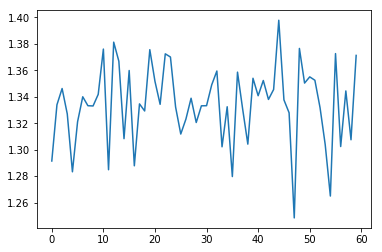

In [10]:
plt.plot(printLoss)

In [ ]:
params = dict()
params['lr'] = 1e-3
params['batch_size'] = 128
params['epoch_limit'] = 2
params['w_decay'] = 1
params['negNum_test'] = 1000
params['epsilon'] = 1e-2
params['negNum_train'] = 4
params['l_size'] = 100
params['gpu']= False

In [ ]:
print("start loading data...")
category = 'Baby'
train, val, test = data_loader.read_data(category)
item_price = data_loader.get_price(category)
item_related = data_loader.get_related(category)
distribution = data_loader.get_distribution(category)
trainset = data_loader.TransactionData(train, item_related, \
            item_price, distribution)
valset = data_loader.UserTransactionData(val, item_price, \
            trainset.itemNum, trainset.userHist)
testset = data_loader.UserTransactionData(test, item_price, \
            trainset.itemNum, trainset.userHist)
avg_rating = trainset.get_avgRating()

Rating = MF(userLen = trainset.userNum, itemLen = trainset.itemNum,\
         avg_rating = avg_rating,params = params)

optimizer_r = opt.SGD(Rating.parameters(), lr = params['lr'], \
                weight_decay = params['w_decay'])

criterion_rating = nn.MSELoss(reduction = 'sum')
criterion_risk = nn.MSELoss(reduction = 'sum')
criterion_MUD = nn.LogSoftmax(dim=0)

trainset.set_negN(params['negNum_train'])
trainLoader = DataLoader(trainset, batch_size = params['batch_size'], \
                        shuffle = True, num_workers = 0)
valset.set_negN(params['negNum_test'])
valLoader = DataLoader(valset, batch_size = 1, \
                        shuffle = True, num_workers = 0)
testset.set_negN(params['negNum_test'])
testLoader = DataLoader(testset, batch_size = 1, \
                        shuffle = True, num_workers = 0)

epsilon = params['epsilon']
epoch = 0
error = np.float('inf')

In [ ]:
print("finish loading, start pretraining the rating matrix...")
while epoch < params['epoch_limit']:
    runningLoss = []
    epoch += 1
    print("Epoch " + str(epoch) + " training...")
    L = len(trainLoader.dataset)
    pbar = tqdm(total=L)
    for i, batchData in enumerate(trainLoader):
        optimizer_r.zero_grad()
        # get input
        users = torch.LongTensor(batchData['user'])#.to(Rating.device)
        items = torch.LongTensor(batchData['item'])#.to(Rating.device)
        pre_r = Rating.forward(users, items)
        r = torch.FloatTensor(batchData['rating'])#.to(Rating.device)

        loss = criterion_rating(pre_r, r)
        loss.backward()
        optimizer_r.step()
        runningLoss.append(loss.item())

        pbar.update(users.shape[0])
    pbar.close()
    meanMSE = np.mean(np.array(runningLoss))
    improvement = np.abs(error - meanMSE)
    error = meanMSE
    if improvement <= epsilon:
        print('pre-train stop early')
        break

In [ ]:
users = torch.LongTensor([0,1,2,3,4,5,6,7,8,9])
items = torch.LongTensor([0,1,2,3,4,5,6,7,8,9])
Ratings.forward(users,items)

In [ ]:
params = dict()
params['lr'] = 1e-4
params['decay_rate'] = 0
params['batch_size'] = 1024
params['epoch_limit'] = 5
params['w_decay'] = 0.5
params['negNum_test'] = 1000
params['epsilon'] = 1e-2
params['negNum_train'] = 4
params['l_size'] = 100
params['gpu']= False

In [ ]:
# criterion_risk = nn.MSELoss(reduction = 'mean')

In [ ]:
"""
ROM 
"""
model = MUD(userLen = trainset.userNum, itemLen = trainset.itemNum,\
         distribution = distribution, item_price = item_price, \
         RMF = Rating, params = params)
optimizer = opt.Adagrad(model.parameters(), lr = params['lr'], \
            lr_decay = params['decay_rate'], weight_decay = params['w_decay'])

epsilon = params['epsilon']
epoch = 0
error = np.float('inf')

trainErrorList = []
valErrorList = []
valHistory = []
explodeTempreture = 3
convergenceTempreture = 3


print("starting ROM model")
lossbar = []
while epoch < params['epoch_limit']:
    epoch += 1
    print("Epoch " + str(epoch) + " outer training...")
    L = len(trainLoader.dataset)
    pbar = tqdm(total = L)
    for i, batchData in enumerate(trainLoader):
#         if i >= 5:
#             break
        optimizer.zero_grad()

        users = torch.LongTensor(batchData['user']).to(model.device)
        items = torch.LongTensor(batchData['item']).to(model.device)
        negItems = torch.LongTensor(batchData['negItem']).reshape(-1).to(model.device)
        nusers = users.view(-1,1) 
        nusers = nusers.expand(nusers.shape[0], params['negNum_train']).reshape(-1)

        pOut = model.forward(users,items).view(-1,1)
        nOut = model.forward(nusers, negItems)
        nOut = nOut.reshape(-1,params["negNum_train"])
        totalOut = torch.cat((pOut,nOut),dim=1)

        loss = - torch.mean(criterion_MUD(totalOut)[:,0])
        lossbar.append(loss)
        loss.backward()
        optimizer.step()
        pbar.update(users.shape[0])
    pbar.close()

#     print("Epoch " + str(epoch) + " inner training...")
#     pbar = tqdm(total = L)
#     for i, batchData in enumerate(trainLoader):
#         optimizer.zero_grad()
#         users = torch.LongTensor(batchData['user']).to(model.device)
#         items = torch.LongTensor(batchData['user']).to(model.device)

#         eu = model.EU(users,items)
#         ue = model.UE(users,items)

#         loss = criterion_risk(ue, eu)
#         lossbar.append(loss)
# #         print('loss: %s' % loss)
#         loss.backward()
#         optimizer.step()
#         pbar.update(users.shape[0])
#     pbar.close()

    #validation
#         print("Epoch " + str(epoch) + " validating...")
#         L = len(valLoader.dataset)
#         pbar = tqdm(total = L)
#         model.eval()
#         with torch.no_grad():
#             scoreDict = dict()
#             for i, batchData in enumerate(valLoader):
#                 user = torch.LongTensor(batchData['user'])#.to(model.device)
#                 posItems = torch.LongTensor(batchData['posItem'])#.to(model.device)
#                 negItems = torch.LongTensor(batchData['negItem'])#.to(model.device)
#                 budget = torch.FloatTensor(batchData['budget'])#.to(model.device)
#                 posPrices = torch.FloatTensor(batchData['posPrice'])#.to(model.device)
#                 negPrices = torch.FloatTensor(batchData['negPrice'])#.to(model.device)

#                 items = torch.cat((posItems, negItems),1).view(-1)
#                 prices = torch.cat((posPrices, negPrices),1).view(-1)
#                 users = user.expand(items.shape[0])

#                 out = model.forward(users,items)
#                 scoreHeap = list()
#                 for j in range(out.shape[0]):
#                     gt = False
#                     if j < posItems.shape[1]:
#                         gt = True
                # if prices[j] > budget:
                #     heappush(scoreHeap, (100, (0 + items[j].cpu().numpy(), gt)))
                # else:
                #     heappush(scoreHeap, (1 - out[j].cpu().numpy(), (0 + items[j].cpu().numpy(), gt)))
#                 scores = list()
#                 candidate = len(scoreHeap)
#                 for k in range(candidate):
#                     scores.append(heappop(scoreHeap))
#                 pbar.update(1)
#                 scoreDict[user[0]] = (scores, posItems.shape[1])
#         pbar.close()

#         valHistory.append(evaluation.ranking_performance(scoreDict,10))
#         valError = 1 - valHistory[-1]["avg_ndcg"][0]
#         valErrorList.append(valError)
#         improvement = np.abs(error - valError)
#         error = valError
#         if improvement < epsilon:
#             print("stop early")
#             break

    
plt.plot(lossbar)
    
print("start testing...")
L = len(testLoader.dataset)
pbar = tqdm(total = L)
with torch.no_grad():
    scoreDict = dict()
    for i, batchData in enumerate(testLoader):
        if i >= 1000:
            break
        user = torch.LongTensor(batchData['user']).to(model.device)
        posItems = torch.LongTensor(batchData['posItem']).to(model.device)
        negItems = torch.LongTensor(batchData['negItem']).to(model.device)
        budget = torch.FloatTensor(batchData['budget']).to(model.device)
        posPrices = torch.FloatTensor(batchData['posPrice']).to(model.device)
        negPrices = torch.FloatTensor(batchData['negPrice']).to(model.device)

        items = torch.cat((posItems, negItems),1).view(-1)
        prices = torch.cat((posPrices, negPrices),1).view(-1)
        users = user.expand(items.shape[0])

        out = model.forward(users,items)
#         print(out)
        scoreHeap = list()
        for j in range(out.shape[0]):
            gt = False
            if j < posItems.shape[1]:
                gt = True
#                 if prices[j] > budget:
#                     heappush(scoreHeap, (1000000, (0 + items[j].cpu().numpy(), gt)))
#                 else:
#                     heappush(scoreHeap, (1 - out[j].cpu().numpy(), (0 + items[j].cpu().numpy(), gt)))
            heappush(scoreHeap, (1 - out[j].cpu().numpy(), (0 + items[j].cpu().numpy(), gt)))
        scores = list()
        candidate = len(scoreHeap)
        for k in range(candidate):
            scores.append(heappop(scoreHeap))
        pbar.update(1)
        scoreDict[user[0]] = (scores, posItems.shape[1])
pbar.close()
testResult = evaluation.ranking_performance(scoreDict,10)

128 Precision@: {1:0.001; 5: 0.0012; 10: 0.0012}
256 Precision@: {1:0.0; 5: 0.0004; 10: 0.0005}
80 Precision@: {1:0.001; 5: 0.0012; 10: 0.0015}
    
1e-2 Precision@: {1:0.0; 5: 0.0006; 10: 0.0006}
5e-2 Precision@: {1:0.0; 5: 0.0006; 10: 0.0009}
1 Precision@: {1:0.001; 5: 0.0012; 10: 0.001}

epoch 2 1e-2 Precision@: {1:0.0; 5: 0.0006; 10: 0.0011}
epoch 3 1e-2 Precision@: {1:0.0; 5: 0.0006; 10: 0.0006}
epoch 3 1e-1 Precision@: {1:0.0; 5: 0.0002; 10: 0.0006}
epoch 3 5e-2 Precision@: {1:0.0; 5: 0.0004; 10: 0.0003}
epoch 3 1e-3 Precision@: {1:0.002; 5: 0.0016; 10: 0.0012}
epoch 4 1e-3 Precision@: {1:0.002; 5: 0.0018; 10: 0.0015}
epoch 5 1e-3 Precision@: {1:0.001; 5: 0.0012; 10: 0.0022}
epoch 10 1e-3 Precision@: {1:0.0; 5: 0.0006; 10: 0.0008}

decay 0.5 Precision@: {1:0.006; 5: 0.0026; 10: 0.002}
decay 0.3 Precision@: {1:0.003; 5: 0.0016; 10: 0.0017}
decay 0.7 Precision@: {1:0.003; 5: 0.0016; 10: 0.0013}

embedding 128 Precision@: {1:0.0; 5: 0.0008; 10: 0.0009}
embedding 24 Precision@: {1:0.001; 5: 0.0018; 10: 0.0012}
embedding 100 Precision@: {1:0.005; 5: 0.0024; 10: 0.0015}




In [ ]:
print("start testing...")
L = len(testLoader.dataset)
pbar = tqdm(total = L)
with torch.no_grad():
    scoreDict = dict()
    for i, batchData in enumerate(testLoader):
        if i >= 1000:
            break
        user = torch.LongTensor(batchData['user']).to(model.device)
        posItems = torch.LongTensor(batchData['posItem']).to(model.device)
        negItems = torch.LongTensor(batchData['negItem']).to(model.device)
        budget = torch.FloatTensor(batchData['budget']).to(model.device)
        posPrices = torch.FloatTensor(batchData['posPrice']).to(model.device)
        negPrices = torch.FloatTensor(batchData['negPrice']).to(model.device)

        items = torch.cat((posItems, negItems),1).view(-1)
        prices = torch.cat((posPrices, negPrices),1).view(-1)
        users = user.expand(items.shape[0])

        out = model.forward(users,items)
#         print(out)
        scoreHeap = list()
        for j in range(out.shape[0]):
            gt = False
            if j < posItems.shape[1]:
                gt = True
#                 if prices[j] > budget:
#                     heappush(scoreHeap, (1000000, (0 + items[j].cpu().numpy(), gt)))
#                 else:
#                     heappush(scoreHeap, (1 - out[j].cpu().numpy(), (0 + items[j].cpu().numpy(), gt)))
            heappush(scoreHeap, (1 - out[j].cpu().numpy(), (0 + items[j].cpu().numpy(), gt)))
        scores = list()
        candidate = len(scoreHeap)
        for k in range(candidate):
            scores.append(heappop(scoreHeap))
        pbar.update(1)
        scoreDict[user[0]] = (scores, posItems.shape[1])
pbar.close()
testResult = evaluation.ranking_performance(scoreDict,10)

In [ ]:
import matplotlib

In [ ]:
plt.plot(lossbar,'.')